# User Lifecycle plots
Plotting user lifecycle and acculturation gap for subreddits

In [1]:
import os

os.chdir('/homes/gws/taugust/ARK/community_guidelines')

%run Reddit/SRILM_building_funcs.ipynb

In [2]:
subs = ['science', 'politics', 'BabyBumps']
slms = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Gettting SRILM SLMs for ', colored(s, 'magenta'))
    print('-----------------------------------------------')
    slms[s] = build_monthly_SLM_SRILM(None, None, 10, name=s, use_saved_lms=True, kind='comment')
    

-----------------------------------------------
Gettting SRILM SLMs for  science
-----------------------------------------------
-----------------------------------------------
Gettting SRILM SLMs for  politics
-----------------------------------------------
-----------------------------------------------
Gettting SRILM SLMs for  BabyBumps
-----------------------------------------------


In [3]:
#########################################
# Showing how user cross entropy reduces 
# as authors continue to post in a community. 
#########################################

# Take all users with 1+ posts over every month (long term users) from test author counts
def active_through_months(author_row, months=[str(m) for m in range(1,6)], threshold=5):    
    return author_row[months].apply(lambda x: x > threshold).all()

# Take all users with 1+ posts over every month (long term users) from test author counts
def inactive_through_months(author_row, months=[str(m) for m in range(6,13)], threshold=0):    
    return author_row[months].apply(lambda x: x <= threshold).all()

def get_long_term_users(author_df, kind, threshold):
    inactive_months = [str(m) for m in range(1,2)]
    active_months = [str(m) for m in range(2,13)]
    
    if kind:
        author_df = author_df[author_df['kind'] == kind]
        
    print(inactive_months, active_months)
    
    df_new_authors = author_df[author_df.apply(lambda row: inactive_through_months(row, months=inactive_months, threshold=0) , axis=1)]

    df_long_term_authors = df_new_authors[df_new_authors.apply(lambda row: active_through_months(row, months=active_months, threshold=threshold) , axis=1)]
    
#     display(df_long_term_authors)

    
#     display(df_new_authors)
    

    return df_long_term_authors
  

# utility function for getting all text from a single user give a df
# the df will either be from comments or posts,
# text_col allowes for indexing in either (default is comments' 'body')
# NOTE: THIS DOES NOT MODIFY THE BODY TEXT
def get_single_user_text_df(df, author, num_posts=None, text_col='body'):
    df_author = df[df['author'] == author]
    if num_posts:
        return df_author.sample(num_posts)
    else: 
        return df_author 
        

# utility function for getting all the text from a list of users given a df
def get_all_user_text_df(df, authors, num_posts=None, text_col='body'):
    df_author = df[df['author'].apply(lambda x: x in authors)]
    if num_posts:
        sampled_comments = pd.Dataframe()
        df_grouped = df_author.groupby('author')
        for a, g in df_grouped:
            sample = g.sample(num_posts)
            sampled_comments.append(sample)
        return sampled_comments
    else:   
        return df_author


def get_long_term_comments(df_comments, authors, num_posts=None):
    long_term_comments = {a:{} for a in authors}
    for a in authors:
        for m in MONTHS:
            long_term_comments[a][m] = get_user_comments(df_comments, authors=a, month=m, num_posts=num_posts)
    return long_term_comments


def get_long_term_text(s, slms_subs, kind, sample_fract=.25): 
    df_comments, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv')   
    threshold = 2  
    print('Getting long term authors with more than', colored(str(threshold)+ ' comments(s) ', 'red'), '.....', end='')
    long_term_authors = get_long_term_users(df_author_counts_test, kind=kind, threshold=threshold).sample(frac=sample_fract)
    print('Done')   
    print('Sampled ', colored(str(len(long_term_authors))+ ' authors ', 'green'), 'and getting all text from each....', end='')
    df_long_term_user_text = get_all_user_text_df(df_comments, list(long_term_authors['author']))
    print('Done')
    return df_long_term_user_text
    

def get_long_term_user_entropy(long_term_text, slms):
    author_grouped = long_term_text.groupby('author')
    rows = []
    for a, g in author_grouped:
        print('Mapping entropy for author', colored(a, 'blue'), '.....', end='')
        for month, month_group in g.groupby('created_month'):
            month_group['text'] = month_group['body'].apply(lambda x:[w.lower() for w in word_tokenize(x)[:10]])
            text_file = export_text(month_group['text'].values,'science_long_term_author_' + a + '_month_' + str(month), corpus_path='/tmp/')
            entropy = calc_month_entropy_SRILM(slms[int(month)], text_file)
            row = {'author': a, 'month':month, 'entropy':entropy}
            rows.append(row)
        print('Done')
    df_entropy = pd.DataFrame(rows)
    df_entropy['mean_entropy'] = df_entropy['entropy'].apply(lambda x: np.mean(x))
#     sns.lineplot(x='month', y='mean_entropy', hue='author', data=df_entropy)
    return df_entropy
    


In [125]:
subs = ['science', 'politics', 'BabyBumps']

plt.figure(figsize=(10,10))

for s in subs:
    df_long_term_text = get_long_term_text(s, slms)
    df_entropy = get_long_term_user_entropy(df_long_term_text, slms[s])

Mapping entropy for author durtysox .....

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


Done
Mapping entropy for author freyascats .....Done
Mapping entropy for author hamnapkin2 .....Done
Mapping entropy for author hersheykiss7761 .....Done
Mapping entropy for author peachykeen5 .....Done
Mapping entropy for author pleasesendbrunch .....Done
Mapping entropy for author proseccho .....Done


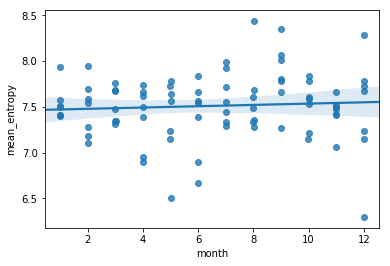

In [90]:
df_long_term_text = get_long_term_text('BabyBumps', slms, sample_fract=1)
df_entropy = get_long_term_user_entropy(df_long_term_text, slms[s])
sns.regplot(x="month", y="mean_entropy", data=df_entropy, x_jitter=.01)

Importing  data/cleaned/sub_comments/politics_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/politics_author_counts_test_2017.csv ..... Done
Getting long term authors with more than 2 comments(s)  .....['1'] ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Done
Sampled  1 authors  and getting all text from each....Done
Mapping entropy for author AbsenceVSThinAir .....

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


Done


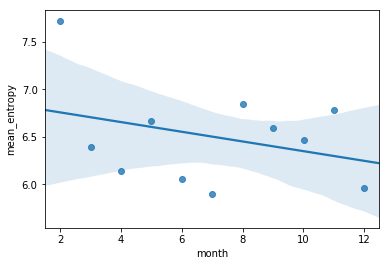

In [156]:
df_long_term_text = get_long_term_text('politics', slms, 'comment', sample_fract=.01)
df_entropy = get_long_term_user_entropy(df_long_term_text, slms[s])
sns.regplot(x="month", y="mean_entropy", data=df_entropy, x_jitter=.01)

In [121]:
# df_comments, df_author_counts_test = import_csvs('science', path='data/cleaned/test/2017/', ext='_test_2017.csv')  
long_term_authors = get_long_term_users(df_author_counts_test, kind='comment', threshold=2).sample(frac=sample_fract)

df_entropy = get_long_term_user_entropy(df_long_term_text, slms[s])
sns.regplot(x="month", y="mean_entropy", data=df_entropy, x_jitter=.01)

['1', '2'] ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


Exception ignored in: <function _get_module_lock.<locals>.cb at 0x7f78764432f0>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 182, in cb
KeyboardInterrupt: 


KeyboardInterrupt: 

In [79]:
# long_term_user_text_grouped = df_long_term_user_text.groupby('author')
entropies = pd.DataFrame(columns=['created_month', 'entropy'])
for a, group in long_term_user_text_grouped:
    group['text'] = group['body'].apply(lambda x: [w.lower() for w in word_tokenize(x)[:10]])
    group['entropy'] = group.apply(lambda x:np.mean(calc_entropy_single_text(slms_subs['science'],x['created_month'],x['text'])), axis=1)
    mean_entropy_over_month = pd.DataFrame(group.groupby(['created_month'])['entropy'].mean())
    mean_entropy_over_month = mean_entropy_over_month.reset_index()
    entropies = entropies.append(mean_entropy_over_month)
    display(entropies)

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,created_month,entropy
0,1.0,9.928035
1,2.0,8.664303
2,3.0,10.075780
3,4.0,9.693828
4,5.0,10.381504
5,6.0,10.161422
6,7.0,9.894340
7,8.0,10.049441
8,9.0,9.412704
9,10.0,10.366308


,created_month,entropy
0,1.0,9.928035
1,2.0,8.664303
2,3.0,10.075780
3,4.0,9.693828
4,5.0,10.381504
5,6.0,10.161422
6,7.0,9.894340
7,8.0,10.049441
8,9.0,9.412704
9,10.0,10.366308


,created_month,entropy
0,1.0,9.926711
1,2.0,9.578402
2,3.0,9.875482
3,4.0,9.555723
4,5.0,9.918281
5,6.0,9.733381
6,7.0,9.241108
7,8.0,9.994446
8,9.0,9.541078
9,10.0,9.645633


,created_month,entropy
0,1.0,9.928035
1,2.0,8.664303
2,3.0,10.075780
3,4.0,9.693828
4,5.0,10.381504
5,6.0,10.161422
6,7.0,9.894340
7,8.0,10.049441
8,9.0,9.412704
9,10.0,10.366308


,created_month,entropy
0,1.0,9.540632
1,2.0,9.816708
2,3.0,9.787126
3,4.0,9.815426
4,5.0,9.978470
5,6.0,10.090053
6,7.0,10.004199
7,8.0,10.172938
8,9.0,9.834097
9,10.0,9.482031


,created_month,entropy
0,1.0,9.928035
1,2.0,8.664303
2,3.0,10.075780
3,4.0,9.693828
4,5.0,10.381504
5,6.0,10.161422
6,7.0,9.894340
7,8.0,10.049441
8,9.0,9.412704
9,10.0,10.366308


,created_month,entropy
0,1.0,10.057765
1,2.0,10.138810
2,3.0,10.130378
3,4.0,9.959372
4,5.0,10.182859
5,6.0,9.904069
6,7.0,9.887024
7,8.0,10.254814
8,9.0,9.665391
9,10.0,9.977715


,created_month,entropy
0,1.0,9.928035
1,2.0,8.664303
2,3.0,10.075780
3,4.0,9.693828
4,5.0,10.381504
5,6.0,10.161422
6,7.0,9.894340
7,8.0,10.049441
8,9.0,9.412704
9,10.0,10.366308


,created_month,entropy
0,1.0,9.609364
1,2.0,8.693321
2,3.0,9.811749
3,4.0,10.171303
4,5.0,9.991879
5,6.0,9.757742
6,7.0,9.138558
7,8.0,9.307986
8,9.0,9.539036
9,10.0,9.160705


,created_month,entropy
0,1.0,9.928035
1,2.0,8.664303
2,3.0,10.075780
3,4.0,9.693828
4,5.0,10.381504
5,6.0,10.161422
6,7.0,9.894340
7,8.0,10.049441
8,9.0,9.412704
9,10.0,10.366308


KeyboardInterrupt: 

# Trying grouping by author posts rather than month
for each post, calculate entropy for the SLM of that month -- will need to do this elementwise since if you group by month SRILM will average the sentences
bin by 10% for each user, then plot by bins 

In [8]:
import uuid

In [25]:
# Take people with over n posts
def get_total_active_user(author_df, kind, threshold):
    author_df = author_df[author_df['kind'] == kind]
    # get total number of user posts
    for_months = [str(i) for i in range(1,13)]
    author_df['total'] = author_df[for_months].sum(axis=1, numeric_only=True)
    return author_df[author_df['total'] > threshold]

def get_SRILM_SLM_entropy_single_text(line, slms):
    # make random name, since this will be stored in tmp and doesn't really matter 
    name = str(uuid.uuid4())
    line_path = export_text([line], name=name, corpus_path='data/tmp/')
    entropy = calc_month_entropy_SRILM(slms, line_path)
    return entropy



In [10]:
df_comments_science, df_author_counts_test_science = import_csvs('science', path='data/cleaned/test/2017/', ext='_test_2017.csv')   
author_df = get_total_active_user(df_author_counts_test_science, 'comment', 50)
text_df = get_all_user_text_df(df_comments_science, list(author_df['author']), num_posts=None, text_col='body')


Importing  data/cleaned/sub_comments/science_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/science_author_counts_test_2017.csv ..... Done


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
text_df['text'] = text_df.body.apply(lambda x: [w.lower() for w in word_tokenize(x)][:10])

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
slms_science = slms['science']

In [32]:

# for each post, calculate entropy for the SLM of that month -- will need to do this elementwise since if you group by month SRILM will average the sentences
# bin by 10% for each user, then plot by bins 

_test_text_df = text_df.sample(2000)
slms_science = slms['science']
_test_text_df['entropy'] = _test_text_df.apply(lambda row: 
                                   get_SRILM_SLM_entropy_single_text(row['text'], slms_science[row['created_month']])
                                   ,axis=1)
_test_text_df['mean_entropy'] = _test_text_df['entropy'].apply(np.mean)

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


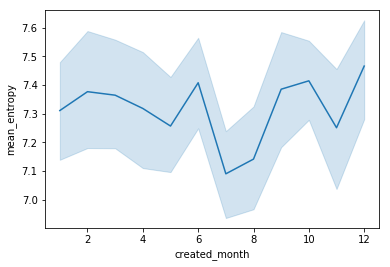

In [34]:
sns.lineplot(x='created_month', y='mean_entropy', data=_test_text_df)

In [17]:
# Compare all long term users posts to calculated SLMs for the month that post was made. 
long_term_authors = get_long_term_users(df_author_counts_test, threshold=1)
authors = list(long_term_authors['author'])
long_term_authors_text_df = get_all_user_text_df(df_comments, authors=authors,num_posts=None)

In [25]:
long_term_authors = get_long_term_users(df_author_counts_test, threshold=1)
authors = list(long_term_authors['author'])
long_term_comments_science = get_long_term_comments(df_comments,authors)
long_term_acc_gap_science = get_long_term_acc_gap(authors,long_term_comments_science, slms_subs['science'])

In [30]:
long_term_acc_gap_science

In [29]:
plt.figure(figsize=(10,5))

for a in long_term_acc_gap_science.keys():
    ax = sns.lineplot(x=list(long_term_acc_gap_science[a].keys()), y=list(long_term_acc_gap_science[a].values()))
    
ax.set_title('Acculturation Gap mean for user lifespan(1 yr)', fontsize=10)
ax.set_xlabel('Month', fontsize=10)
ax.set_ylabel('Gap')
# ax.legend(subs_acc.keys(), loc='upper left')

AttributeError: 'NoneType' object has no attribute 'keys'

<Figure size 720x360 with 0 Axes>

In [5]:
# def calc_entropy_single_text(slms_month_dict, month, text):
#     slms = slms_month_dict[month]
#     text_bigrams = list(ngrams(text, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
#     entropies = []
#     for slm in slms:
#         slm_entropy = check_ent(slm, text_bigrams)
#         entropies.append(slm_entropy)
#     return entropies

# def get_long_term_acc_gap(authors, long_term_comments, slms):
#     long_term_acc_gap= {a:{} for a in authors}
#     for a in authors:
#         for m in range(1,13):
#             long_term_acc_gap[a][m] = np.mean(calc_month_acc_gap(slms, m, long_term_comments[a][m]))
#     return long_term_acc_gap
    
# def get_long_term_user_acc_gap(df_comments, df_author_counts, slms, threshold=1):
#     long_term_authors = get_long_term_users(df_author_counts, threshold=threshold)
#     authors = list(long_term_authors['author'])
#     long_term_comments = get_long_term_comments(df_comments,authors)
#     long_term_acc_gap = get_long_term_acc_gap(authors,long_term_comments_science, slms_subs['science'])
#     return long_term_acc_gap